In [1]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/labeled_training (2).csv')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_2024_Task6_Dev.csv')

In [2]:
import re
import pandas as pd
def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_train['text'] = df_train['text'].apply(preprocess_text)
df_dev['text'] = df_dev['text'].apply(preprocess_text)

In [3]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [4]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy, TrainerCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
class SaveModelCallback(TrainerCallback):
    def __init__(self, output_dir):
        self.output_dir = output_dir
    def on_epoch_end(self, args, state, control, **kwargs):
        output_dir = os.path.join(self.output_dir, f"epoch_debertav3large_{state.epoch}")
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large', num_labels=2) # Adjust num_labels as per your requirement
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.NO,
    load_best_model_at_end=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[SaveModelCallback(output_dir='./model_saves')]
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Step,Training Loss
100,0.620200
200,0.574100
300,0.515800
400,0.550800
500,0.513800
600,0.548200
700,0.479600
800,0.437400
900,0.436000
1000,0.443600


TrainOutput(global_step=22000, training_loss=0.5624979244578968, metrics={'train_runtime': 5023.1326, 'train_samples_per_second': 17.519, 'train_steps_per_second': 4.38, 'total_flos': 2.2104396249408e+16, 'train_loss': 0.5624979244578968, 'epoch': 10.0})

In [5]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

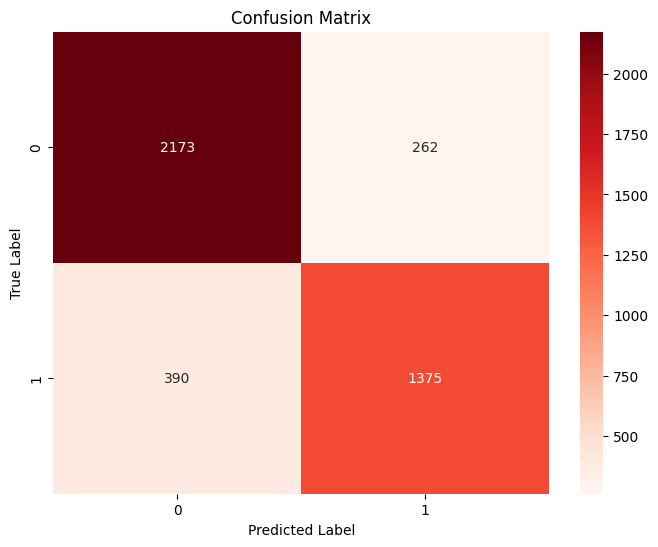

Accuracy: 0.8447619047619047
F1 Score (Class 1): 0.8083480305702527
Recall (Macro): 0.835719645630588
Precision (Macro): 0.8438928494903388


In [6]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_1.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_1['label']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('DeBertaLarge_task6_predictions_001_epoch_1.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

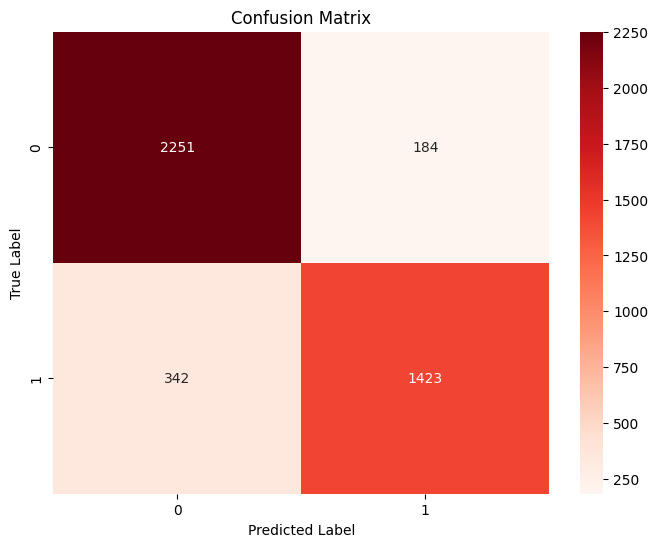

Accuracy: 0.8747619047619047
F1 Score (Class 1): 0.8440094899169632
Recall (Macro): 0.8653338064463589
Precision (Macro): 0.8768036869164049


In [7]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_2.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_2['label']                                                                                                   #THIS
predicted_labels = df_merged_2['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('DeBertaLarge_task6_predictions_001_epoch_2.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

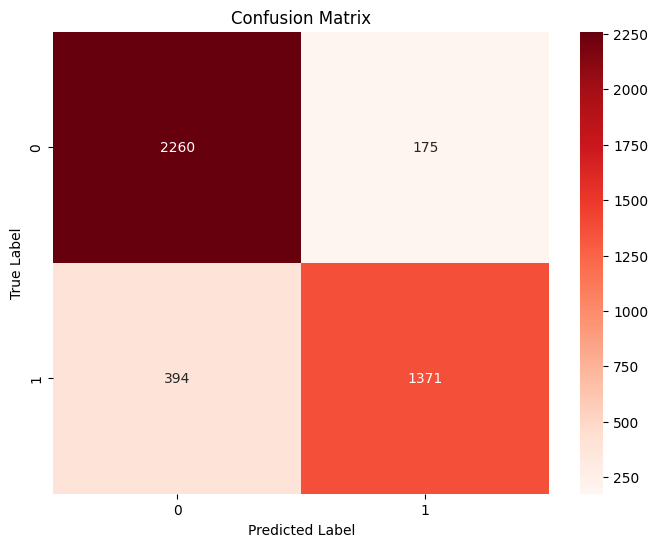

Accuracy: 0.8645238095238095
F1 Score (Class 1): 0.8281485955904561
Recall (Macro): 0.8524509775407042
Precision (Macro): 0.8691747475801129


In [8]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_3.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_3['label']                                                                                                   #THIS
predicted_labels = df_merged_3['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('DeBertaLarge_task6_predictions_001_epoch_3.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

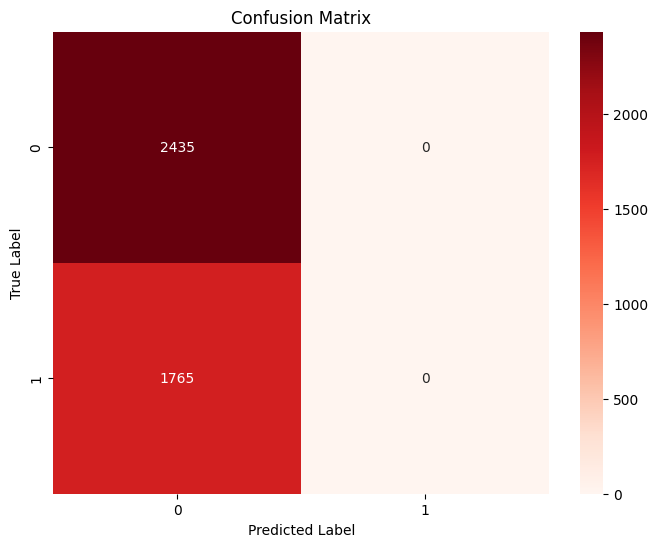

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_4.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_4['label']                                                                                                   #THIS
predicted_labels = df_merged_4['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('DeBertaLarge_task6_predictions_001_epoch_4.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

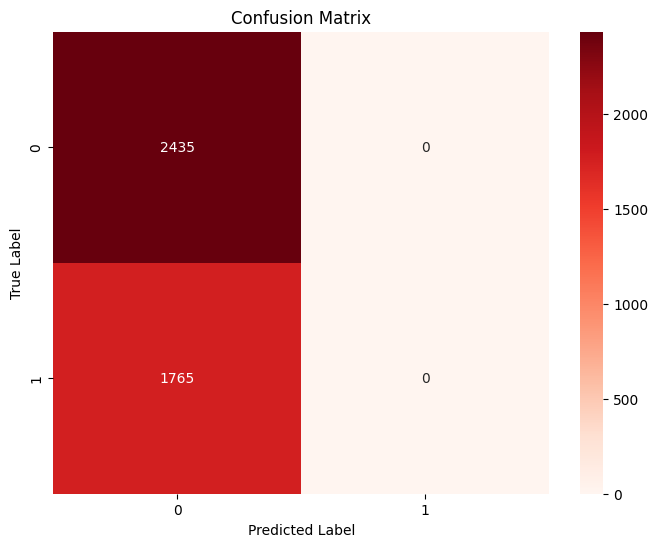

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_5.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_5['label']                                                                                                   #THIS
predicted_labels = df_merged_5['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('DeBertaLarge_task6_predictions_001_epoch_5.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

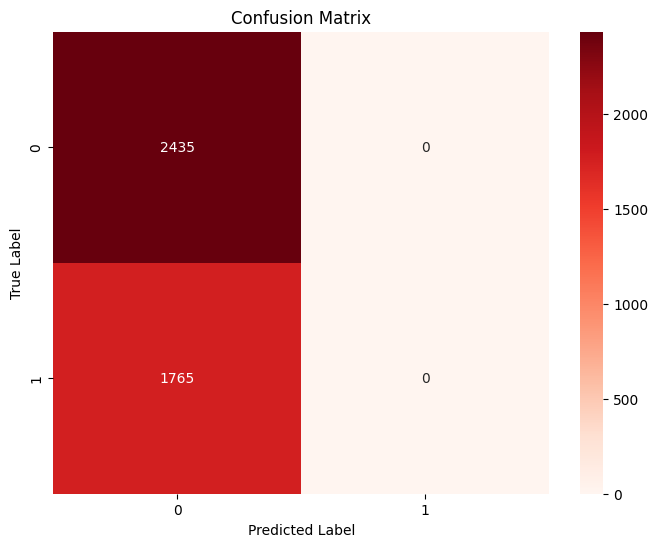

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_6.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_6 = pd.concat([df_dev, df_predictions_6], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_6['label']                                                                                                   #THIS
predicted_labels = df_merged_6['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('DeBertaLarge_task6_predictions_001_epoch_6.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

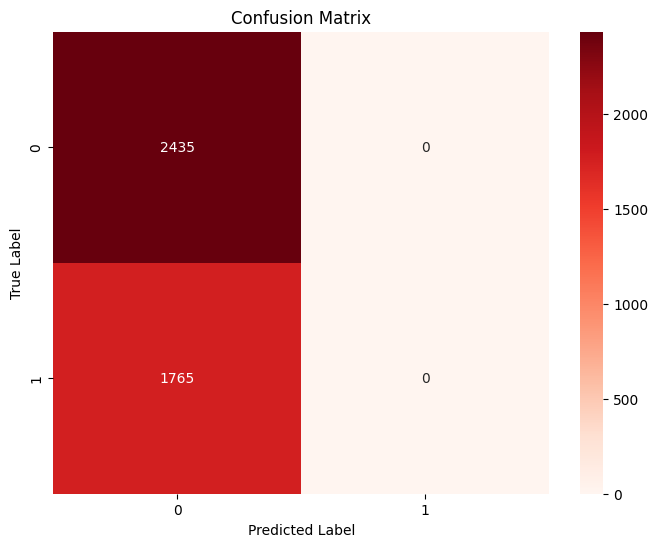

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_7.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_7 = pd.concat([df_dev, df_predictions_7], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_7['label']                                                                                                   #THIS
predicted_labels = df_merged_7['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('DeBertaLarge_task6_predictions_001_epoch_7.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

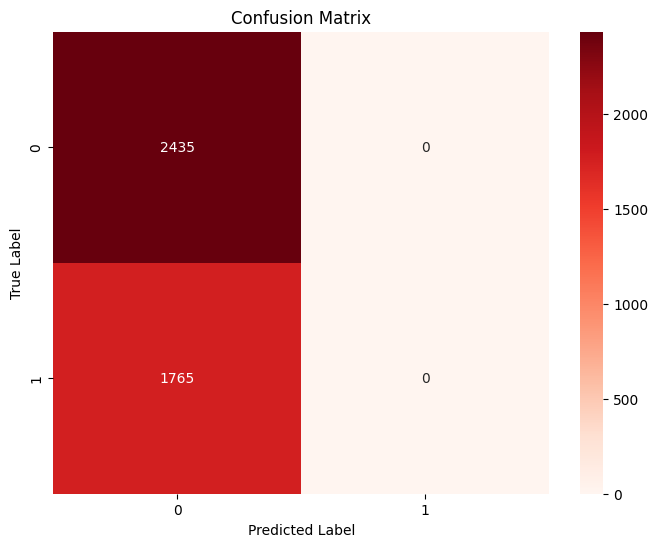

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_8.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_8 = pd.concat([df_dev, df_predictions_8], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_8['label']                                                                                                   #THIS
predicted_labels = df_merged_8['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('DeBertaLarge_task6_predictions_001_epoch_8.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

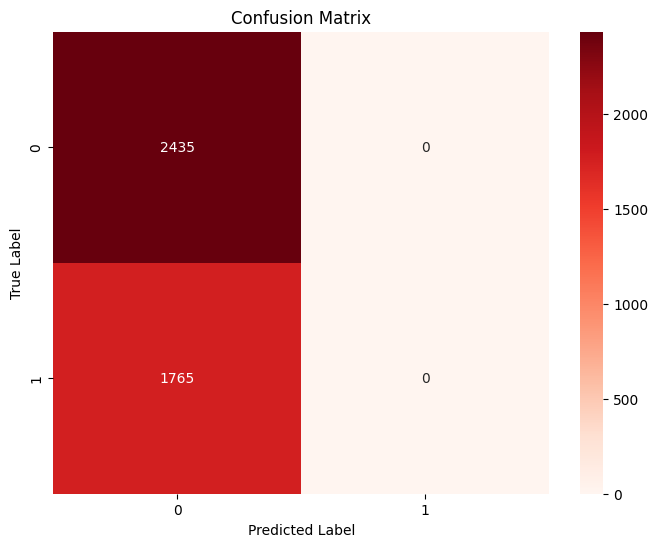

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_9.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_9 = pd.concat([df_dev, df_predictions_9], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_9['label']                                                                                                   #THIS
predicted_labels = df_merged_9['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('DeBertaLarge_task6_predictions_001_epoch_9.csv', index=False)                                             #THIS

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/1050 [00:00<?, ?it/s]

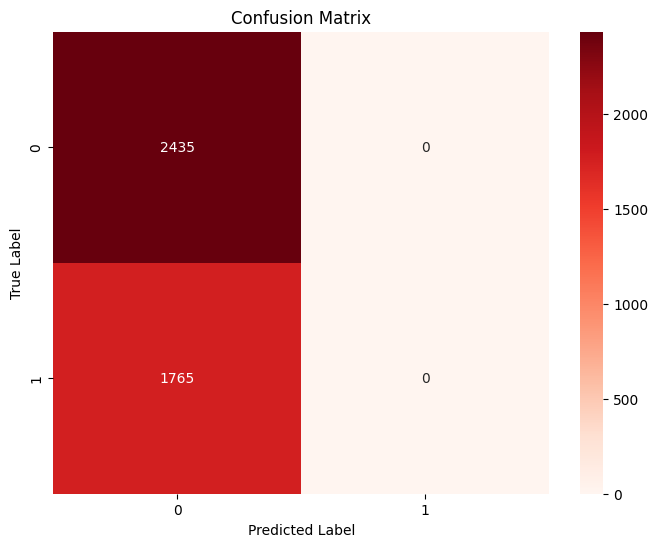

Accuracy: 0.5797619047619048
F1 Score (Class 1): 0.0
Recall (Macro): 0.5
Precision (Macro): 0.2898809523809524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_debertav3large_10.0')                       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_10 = pd.concat([df_dev, df_predictions_10], axis=1)                                                                    #THIS #THIS
true_labels = df_merged_10['label']                                                                                                   #THIS
predicted_labels = df_merged_10['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('DeBertaLarge_task6_predictions_001_epoch_10.csv', index=False)                                             #THIS